# Model-Predictive Path Integral Control Example

In [1]:
%load_ext autoreload
%autoreload 2

## Imports and Parameters

In [19]:
import time
import cv2
from utils import * # imports integrators and other useful things
from system import * # imports system dynamics and objective
from MPPI import MPPI # imports controller
import matplotlib.pyplot as plt
# %matplotlib widget
%matplotlib inline

###################
# System parameters
num_agents = 5
x0 = [np.array([0.35,0,-0.5,0,1.7,0,0.35,-0.5]),
      np.array([-0.35,0,0.5,0,1.7,0,-0.35,0.5]),
      np.array([0,0,0,0,1.7,0,0,0]),
      np.array([-0.45,0,-0.55,0,1.7,0,-0.45,-0.55]),
      np.array([0.45,0,0.55,0,1.7,0,0.45,0.55])]
xd = np.array([0,0,0,0,1.4,0,0,0])
del_t = 0.05
dyn = lambda x, u: SLIP_walker_3D(x,u)

######################
# Objective parameters
w_sz = 8; ov = 0.5;
R = 4.0*np.diag([5.0, 10.0, 10.0])
Q = 1.0*np.diag([0.0, 50.0, 0.0, 50.0, 200.0, 3.0, 0.0, 0.0])
u0 = np.array([0.0, 0.0, 0.0])
var_ind = [0,2]
w1 = 10 # weight on potential
w2 = -2 # weight on rattling (must be negative for diffusion)

#####################
# Image preprocessing
thresh = 0.97
dim = (100, 100)
im_extent = [[-1,1],[-1,1]]
img = cv2.imread('N.png')
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
img_potential = np.array(np.flip(gray.T,axis=1),dtype=np.float64)/np.max(gray)
img_potential[img_potential<thresh] = 0

#############################
# Image samples and objective
n_samp = 300
xlen = np.abs(im_extent[0][1]-im_extent[0][0])
ylen = np.abs(im_extent[1][1]-im_extent[1][0])
target_pts = np.array(np.where(img_potential < thresh),dtype=np.float64).T
xtemp = ((target_pts[:,0]/float(img_potential.shape[0]))*xlen)+im_extent[0][0]
ytemp = ((target_pts[:,1]/float(img_potential.shape[1]))*ylen)+im_extent[1][0]
scaled_pts = np.vstack([xtemp,ytemp]).T
samples = scaled_pts[np.random.choice(range(len(scaled_pts[:,0])),size=n_samp)]
obj = lambda x, u: image_objective(x, u, img_potential, samples, im_extent, var_ind, del_t, w1, w2, w_sz, ov, xd, Q, R)

#######################
# Controller parameters
noise_mean = np.array([0.0, 0.0, 0.0])
noise_var = 0.01*np.diag([1.0, 0.1, 0.1])
samp_num = 20
predictive_horizon = 20 
simulation_length = 2000 
Temp = 1.0

## Initialize Controller

In [20]:
controllers = [MPPI(dyn, obj, x0[i], u0, K=samp_num, N=predictive_horizon, dt=del_t, lamb=Temp, noise_mu=noise_mean, noise_sigma=noise_var) for i in range(num_agents)]

## Main Loop

In [21]:
tstart = time.time()
xlist = []
for i in range(simulation_length):
    for a in range(num_agents):
        u_star = controllers[a].step(x0[a])[:,0]
        x = integrate(dyn,x0[a],u_star,del_t)
        x0[a] = np.copy(x)
    xlist.append(np.array(x0).flatten())
    print_completion(i,simulation_length,tstart)
xtraj = np.array(xlist).T

25% complete. Time elapsed: 113.57s.
50% complete. Time elapsed: 227.99s.
75% complete. Time elapsed: 342.5s.
100% complete. Time elapsed: 453.8s.


## Plot

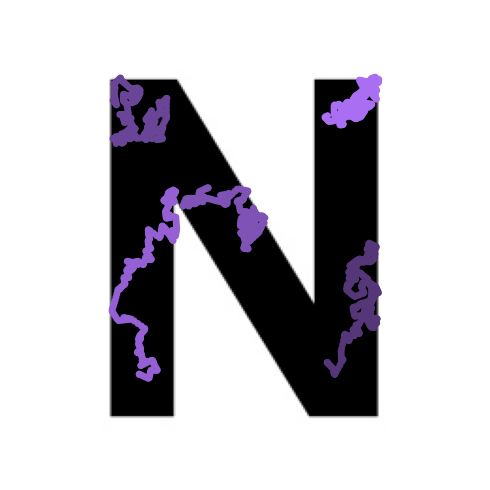

In [22]:
skip = 5; stop = -1;
NU_color = 0.9*np.array([94./255., 61./255., 134./255])
clist = [NU_color,1.25*NU_color,1.5*NU_color,1.75*NU_color,2*NU_color]
plt.figure(figsize=(5,5),dpi=100)
plt.imshow(img,cmap="gist_gray",extent=display_range)
for i in range(num_agents):
    plt.scatter(xtraj[var_ind[0]+i*x0[0].shape[0],:stop:skip],xtraj[var_ind[1]+i*x0[0].shape[0],:stop:skip],color=clist[i],s=25,marker='o',edgecolor='none')
plt.xlim([display_range[0],display_range[1]])
plt.ylim([display_range[2],display_range[3]])
plt.axis('off')
plt.tight_layout()
plt.show()

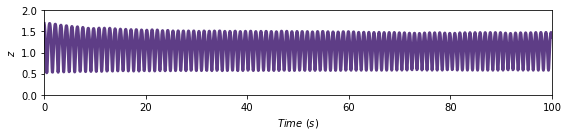

In [23]:
stop = -1
t = np.linspace(0,del_t*simulation_length,simulation_length)
plt.figure(figsize=(8,2))
plt.plot(t[:stop],xtraj[4,:stop],color=(94./255., 61./255., 134./255),linewidth=3)
plt.xlim([t[0],t[stop]])
plt.ylim([0,2])
plt.xlabel(r'$Time\ (s)$')
plt.ylabel(r'$z$')
plt.tight_layout()
plt.show()

In [53]:
plt.close('all')